In [1]:
# Get the Node and Workflow object
from nipype import Node, Workflow
from os.path import join as opj
from os.path import abspath

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

220125-12:14:53,823 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


In [2]:
preproc = Workflow(name='UCLA_Preprocessing', base_dir='/output/')

In [3]:
# Input Anatomical Image and functional Image

from nipype.algorithms.misc import Gunzip

gunzip_anat = Node(Gunzip(), name='gunzip_anat')
gunzip_func = Node(Gunzip(), name='gunzip_func')

In [4]:
# Brain Extraction on anat

from nipype.interfaces.fsl import BET

bet = Node(BET(mask=True), name='brain_extraction')

preproc.connect([(gunzip_anat, bet, [('out_file', 'in_file')])])

In [5]:
# Slice Timing

# Slice time correction
# Repetion Time(TR) = 2
# 34 slices per volume
# accusition time = TR - (TR/34)
# choosing the reference slice as the median

from nipype.interfaces.spm import SliceTiming

num_slices = 34
TR = 2
TA = TR - (TR / num_slices)
slice_order = list(range(1, num_slices+1, 2)) + list(range(2, num_slices+1, 2))

slicetime = Node(SliceTiming(num_slices=num_slices,
                             ref_slice=int(num_slices / 2),
                             slice_order=slice_order,
                             time_repetition=TR,
                             time_acquisition=TA),
                 name='slicetime')

preproc.connect([(gunzip_func, slicetime, [('out_file', 'in_files')])])

In [6]:
# Motion Correction

from nipype.interfaces.fsl import MCFLIRT

mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

preproc.connect([(slicetime, mcflirt, [('timecorrected_files', 'in_file')])])

In [7]:
# Smoothing

from nipype.interfaces.fsl import IsotropicSmooth

smoothing = Node(IsotropicSmooth(fwhm=5),
               name="isotropic_smoothing")

preproc.connect([(mcflirt, smoothing, [('out_file', 'in_file')])])

In [8]:
# Coregistration

from nipype.interfaces.fsl import FLIRT

coreg = Node(FLIRT(dof=7,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

preproc.connect([(bet, coreg, [('out_file', 'reference')]),
                 (smoothing, coreg, [('out_file', 'in_file')])
                 ])

In [12]:
# Input

from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink

experiment_dir = abspath('./output')
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['50020', '50056']

# list of session identifiers
task_list = ['rest']

# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']), name="infosource")
infosource.iterables = [('subject_id', subject_list), ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func', 'sub-{subject_id}_task-{task_name}_bold.nii.gz')
templates = {'anat': anat_file,
             'func': func_file}

selectfiles = Node(SelectFiles(templates, base_directory=abspath('./data/ucla')), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir), name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]

datasink.inputs.substitutions = substitutions

In [13]:
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')])])

preproc.connect([((selectfiles, gunzip_anat, [('anat', 'in_file')]))])
preproc.connect([((selectfiles, gunzip_func, [('func', 'in_file')]))])

220125-12:14:54,350 nipype.workflow INFO:
	 Generated workflow graph: /output/UCLA_Preprocessing/graph.png (graph2use=colored, simple_form=True).


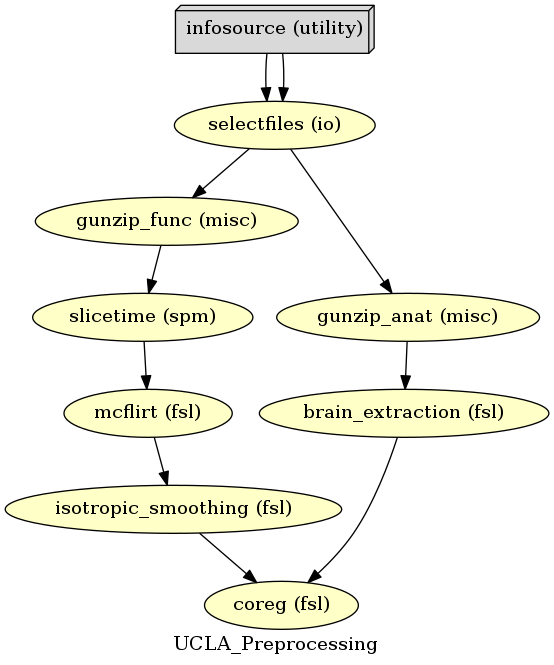

In [14]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='./output/UCLA_Preprocessing/graph.png', width=750)

In [15]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

220125-12:14:54,424 nipype.workflow INFO:
	 Workflow UCLA_Preprocessing settings: ['check', 'execution', 'logging', 'monitoring']
220125-12:14:54,492 nipype.workflow INFO:
	 Running in parallel.
220125-12:14:54,498 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.45/3.45, Free processors: 4/4.
220125-12:14:54,580 nipype.workflow INFO:
	 [Node] Setting-up "UCLA_Preprocessing.selectfiles" in "/output/UCLA_Preprocessing/_subject_id_50020_task_name_rest/selectfiles".
220125-12:14:54,574 nipype.workflow INFO:
	 [Node] Setting-up "UCLA_Preprocessing.selectfiles" in "/output/UCLA_Preprocessing/_subject_id_50056_task_name_rest/selectfiles".
220125-12:14:54,681 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")220125-12:14:54,681 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

220125-12:14:54,772 nipype.workflow INFO:
	 [Node] Finished "UCLA_Preprocessing.selectfiles".
220

mcflirt -in /output/UCLA_Preprocessing/_subject_id_50056_task_name_rest/slicetime/asub-50056_task-rest_bold.nii -meanvol -out /output/UCLA_Preprocessing/_subject_id_50056_task_name_rest/mcflirt/asub-50056_task-rest_bold_mcf.nii.gz -plots

220125-12:16:14,578 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 3.05/3.45, Free processors: 2/4.
                     Currently running:
                       * UCLA_Preprocessing.mcflirt
                       * UCLA_Preprocessing.mcflirt
220125-12:16:43,708 nipype.workflow INFO:
	 [Node] Finished "UCLA_Preprocessing.mcflirt".
220125-12:16:44,71 nipype.workflow INFO:
	 [Node] Finished "UCLA_Preprocessing.mcflirt".
220125-12:16:44,611 nipype.workflow INFO:
	 [Job 3] Completed (UCLA_Preprocessing.mcflirt).
220125-12:16:44,615 nipype.workflow INFO:
	 [Job 11] Completed (UCLA_Preprocessing.mcflirt).
220125-12:16:44,619 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 3.